In [ ]:
import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import scipy.optimize as opt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
_FOLDER = "./data/"

In [ ]:
### General sigmoid_4_param curves
x0 = 0.595
L = 1.015
k = -18.72
d = 0.083
x = np.linspace(0,1, 10)
y = 1/ (L + np.exp(-k*(x-x0))) + d
plt.plot(x,y); 

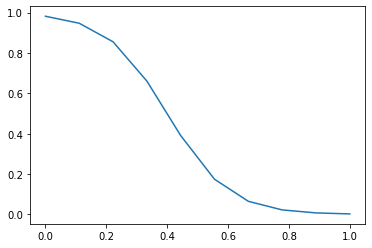

In [8]:
### General sigmoid_4_param curves
x0 = 0.4
L = 1
k = -10
d =0
x = np.linspace(0,1, 10)
y = 1/ (L + np.exp(-k*(x-x0))) + d
plt.plot(x,y); 

In [3]:
### General sigmoid_Wang curves
p = 0.4
s = 0.1
x = np.linspace(0,1, 10)
y = 1.0 / (1.0 + np.exp((x-p)/s))
plt.plot(x,y); 

In [2]:
def sigmoid_Wang(x, p, s):
    """ Sigmoid function from Dennis Wang's paper:
    x - dosage [0, 1],
    p - position,        default=0.4 p=0 no upper plateu, p=1 no lower plateu bounds [0, 1]
    s - shape parameter, default=0.1 s<0= normal sigmoid, s>1=straight line, more s, more horisontal line, 
                         general bounds s>0, but for good drug responses [0,1]
    parameters_bound ((0,0], [1,1)) or (0,1)
    """
    return ( 1.0 / (1.0 + np.exp((x-p)/s)) )

def fsigmoid(x, p, k):
    """ Comparing with Dennis Wang's sigmoid:
    x = x  - dosage [0, 1]
    p - position [0,1],           default = 0.4 bounds = [0,1]
    k = -1/s (s -shape parameter) default = -10 k=0 straight line, k<0 sigmoid around k=-10
    parameters_bound ((0,-100],[1,-1))
    """
    return ( 1.0 / (1.0 + np.exp(-k*(x-p))) )


def sigmoid_4_param(x, x0, L, k, d):
    """ Comparing with Dennis Wang's sigmoid:
    x0 -  p - position, correlation with IC50 or EC50
        bounds [0, 1]
    L = 1 in Dennis Wang's sigmoid, protect from devision by zero if x is too small 
        L<1 inverted sigmoid, l=100 - lower upper and lower boundso sigmpoid on y axis (y= [0.1, 0.11])
        bounds [0.8, 10]
    k = -1/s (s -shape parameter)  default = -10 k=0 straight line, k<0 sigmoid around k=-10
        bounds [1, -100]
    d - determines the vertical position of the sigmoid - shift on y axis - better fitting then Dennis Wang's sigmoid
         bounds [0, 0.9]
    parameters_bound ((0, 0.8, -100, 0), (1, 10, 1, 0.9))
    """
    return ( 1/ (L + np.exp(-k*(x-x0))) + d)


def sigmoid_3_param(x, x0, k, d):
    """ Comparing with Dennis Wang's sigmoid:
    x0 -  p - position, correlation with IC50 or EC50
        bounds [0, 1]
    k = -1/s (s -shape parameter)  default = -10 k=0 straight line, k<0 sigmoid around k=-10
        bounds [1, -100]
    d - determines the vertical position of the sigmoid - shift on y axis - better fitting then Dennis Wang's sigmoid
         bounds [0, 0.9]
    parameters_bound ((0, -100, 0], [1, 1, 0.9))"""
    return ( 1/ (1 + np.exp(-k*(x-x0))) + d )


def ll4(x, e, c, b, d):
    """ https://gist.github.com/yannabraham/5f210fed773785d8b638
    This function is basically a copy of the LL.4 function from the R drc package:
     np.exp( b* (np.log(x)-np.log(e)) -  np.exp((x-p)/s in Dennis Wang's sigmoid
     np.log(x)-np.log(e) == x-p in Dennis Wang's sigmoid
     e - EC50 
         bounds [0.1, 1], default 0.4
     c-d - difference between max and min responses
     c - max response
         bounds [0,1], default 1
     b- hill slope = 1/s - shape parameter
         bounds [0, 50], default 5
     d - min response - determines the vertical position of the graph
         bounds [0,1]
     parameters_bound ((0.1,0,0,0],[1, 1, 50, 1))
   
     """
    return ( (c-d)/(1 + np.exp( b*(np.log(x)-np.log(e) ))) + d)


def ll4_R(x, e, c, b, d):
    """ LL.4 function from R
    https://www.rdocumentation.org/packages/drc/versions/2.5-12/topics/LL.4
    e - EC50 - np.log(concentration) np.log(0.0001)=-10, np.log(1)=0
         bounds [-10, 0], default -5
     c-d - difference between max and min responses
     c - max response
         bounds [0,1], default 1
     b - hill slope = 1/s - shape parameter
         bounds [0, 50], default 5
     d - min response - determines the vertical position of the graph
         bounds [0,1]
     parameters_bound ((-10,0,0,0],[0, 1, 50, 1))

    """
    return ( (c-d)/(1+np.exp(b*np.log(x)- e)) + d)


def logistic4(x, A, B, C, d):
    """ https://people.duke.edu/~ccc14/pcfb/analysis.html
    4PL logistic equation
    Dennis Wang's sigmoid: 1.0 / (1.0 + np.exp((x-p)/s)
    (A - d) = 1 in Dennis Wang's sigmoid:
          bounds [0, 1.5] default A = 1
    (x/C)**B  - corresponds to np.exp((x-p)/s
    B - determines shape/ 0.1 half-sigmoid, 5 -good sigmoid
        bounds [0.1, 50], default B = 5
    C - deterimnes position of the centre of sigmoid
        bounds [0, 1], default C = 0.4
    
    d - determines the vertical position of the sigmoid - shift on y axis 
         bounds [0, 0.9], default d = 0
         
    parameters_bound ((0, 0.1, 0, 0], [1.5, 50, 1, 0.9))
    """
    return ( (A-d)/(1.0+((x/C)**B)) + d )


def logLogistR(x, EC50, HS, E_inf):
    """Python analog for PharmacoGx/R/LogLogisticRegression.R
    https://github.com/bhklab/PharmacoGx/blob/master/R/LogLogisticRegression.R
    E = E_inf + (1 - E_inf)/(1 + (x/EC50)^HS)
    Dennis Wang's sigmoid: 1.0 / (1.0 + np.exp((x-p)/s)
    
    (A - d) = 1 in Dennis Wang's sigmoid:
    (np.log10(x)/EC50)**HS  - (in logistic4 (x/C)**B) corresponds to np.exp((x-p)/s 
    EC50 - concentration, determines shape of a sigmoid and its center
        bounds [0, 1], default 0.4
    HS - determines shape:
        bounds [-30, -2] default -4 only even values work
    E_inf - determines the vertical position of the graph /coefficient d, min response in other functions
        bounds [0, 1]
    parameters_bound ((0,-30,0], [1,-2,1))
    """
    return ((1-E_inf)/(1+(np.log10(x)/EC50)**HS) + E_inf)



def FitCurve(fitting_function, x, y, parameters_guess=None, bounds = (-100, 100), to_plot = False):
#     from scipy.optimize import curve_fit

    if parameters_guess:
        parameters, p_covariance = curve_fit(fitting_function, x, y, parameters_guess, bounds= bounds)
    else: 
        parameters, p_covariance = curve_fit(fitting_function, x, y, bounds= bounds)
    x2 = np.linspace(0, 1, 10)
    y_fit = fitting_function(x, *parameters)
    r2 = r2_score(y, y_fit)

    if to_plot:
        print("Fitting parameters:", *parameters)
        plt.scatter(x, y)
        x2 = np.linspace(0, 1, 10)
        y2 = fitting_function(x2, *parameters)
        plt.plot(x2, y2, "blue", label = "R^2= %0.5f"%r2)   
        plt.title('Least-squares fit')
        plt.legend();
    return r2, parameters


def FittingColumn(df, indexes, x_columns, y_columns, fitting_function, parameters_guess=None, default_param = False):
    """
    intial parameter guess [max(y), np.median(x), 1, min(y)]
    potentially they can be different for each data row, but as soon as we have scaled and filtered data
    we can use by default [1.0, 0.4, 1.0, .0] 
    """
    
    r2_scores = np.zeros(len(indexes))
    X = df.loc[indexes, x_columns].values.astype(np.float32)
    Y = df.loc[indexes, y_columns].values.astype(np.float32)
    fitting_parameters = [None]*len(indexes)
    
    
    # parameters_guess= [np.median(x), 1, max(y), min(y)]
    default_param_model = {"sigmoid_Wang": {"initial_guess": [0.4, 0.1], 
                                             "bounds": (0, 1)},
                           "fsigmoid" : {"initial_guess": [0.4, -10], 
                                          "bounds": ((0,-100), (1,-1))},
                           "sigmoid_4_param": {"initial_guess": [0.4, 1.0, -10, .0], 
                                                "bounds": ((0, 0.8, -100, 0), (1, 10, 1, 0.9))},
                           "sigmoid_3_param": {"initial_guess": [0.4, -10.0, .0],  
                                               "bounds": ((0, -100, 0), (1, 1, 0.9))},
                           "logistic4": {"initial_guess": [1.0, 1.0, 1.0, 0.0], 
                                        "bounds": ((0, 0.1, 0, 0), (1.5, 50, 1, 0.9))},
                            "ll4": {"initial_guess": [0.4, 1.0, 1.0, 0.0], 
                                    "bounds": ((0.1,0,0,0), (1, 1, 50, 1))},
                            "ll4_R": {"initial_guess": [-5, 1.0, 5.0, 0], 
                                 "bounds":((-10,0,0,0), (0, 1.0, 50, 1))},
                            "logLogistR": {"initial_guess": [0.4, -4, 0], 
                                          "bounds":((0,-30,0), (1,-2,1))}}

    if default_param:
        parameters_guess = default_param_model[fitting_function]["initial_guess"]
       
    else:
        pass
    
    for i in tqdm(range(len(indexes))):
        x = X[i, :]
        y = Y[i, :]
    
        
        functions = {"fsigmoid": fsigmoid, 
                 "sigmoid_Wang": sigmoid_Wang, 
                "sigmoid_4_param": sigmoid_4_param,
                 "sigmoid_3_param": sigmoid_3_param, 
                 "logistic4": logistic4,  
                 "ll4": ll4, 
                 "ll4_R": ll4_R,
                 "logLogistR" : logLogistR}
        fitting_function_object = functions[fitting_function]
        try:
            r2_scores[i], fitting_parameters[i] = FitCurve(fitting_function_object, x, y, 
                                                               parameters_guess = parameters_guess,
                                                            bounds = default_param_model[fitting_function]["bounds"])
        except:
            r2_scores[i] = 0
    return r2_scores, fitting_parameters


def ShowResponseCurvesWithFitting(df, plots_in_row, plots_in_column, x_columns, y_columns, start_index=0, indexes=[],
                         fitting_function =None, fitting_parameters =None, pred_fitting_param = None):
    
    print("Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)")
    fig = plt.figure(figsize=(14, 11))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    n_plots= plots_in_row*plots_in_column
    
    if len(indexes) == 0:
        indexes = df.index[start_index : start_index+n_plots]
        
    X = df.loc[indexes, x_columns].values.astype(np.float32)
    Y = df.loc[indexes, y_columns].values.astype(np.float32)
        
    try:
        for i in range(len(indexes)):
            x = X[i, :]
            y = Y[i, :]
            ind = indexes[i]

                
            ax = fig.add_subplot(plots_in_row, plots_in_column, i+1)
            ax.scatter(x,y)
            ax.set_title(str(ind)+"_"+str(df.loc[ind, "DRUG_ID"])+"_"+str(df.loc[ind, "COSMIC_ID"]))
            ax.set_xlabel("Scaled dosage")
            ax.set_ylabel("Normalised response")

            if fitting_function:
                functions = {"fsigmoid": fsigmoid, "sigmoid_Wang": sigmoid_Wang, 
                             "sigmoid_4_param": sigmoid_4_param, "sigmoid_3_param": sigmoid_3_param, 
                             "logistic4": logistic4, "ll4": ll4, "ll4_R": ll4_R, "logLogistR": logLogistR}
                fitting_function_object = functions[fitting_function]
                
#                 from fitting_curves.py import fitting_function_object

                x2 = np.linspace(0, 1, 10)

                if type(fitting_parameters) == str:
                    fit_param = df.loc[ind, fitting_parameters]
                else:
                    fit_param = df.loc[ind, fitting_parameters].values

                y_fit = fitting_function_object(x, *fit_param)
                y2 = fitting_function_object(x2, *fit_param)
                r2 = r2_score(y, y_fit)
                ax.plot(x2, y2, label= "R^2 fit = %0.4f"% r2)
                ax.legend()
            if pred_fitting_param:

                x3 = np.linspace(0, 1, 10) 
                fit_param = df.loc[ind, pred_fitting_param]    
                y_fit3 = fitting_function_object(x, *fit_param)
                y3 = fitting_function_object(x3, *fit_param)
                r2_pred = r2_score(y, y_fit3)
                ax.plot(x3, y3, color="red", label= "R^2 pred = %0.4f"% r2_pred)
                ax.legend()
                
    except:
        print("ERROR: Number of indexes does not correspond to number of graphs to plot")


def compute_r2_score(df, x_columns, y_columns, fitting_parameters, fitting_function="sigmoid_4_param"):
    functions = {"fsigmoid": fsigmoid, "sigmoid_Wang": sigmoid_Wang, 
                             "sigmoid_4_param": sigmoid_4_param, "sigmoid_3_param": sigmoid_3_param, 
                             "logistic4": logistic4, "ll4": ll4, "ll4_R":ll4_R, "logLogistR": logLogistR}
    fitting_function_object = functions[fitting_function]
    r2_scores=np.zeros(len(df.index))
    for i in range(len(df.index)):
        x = df.loc[df.index[i], x_columns]
        y = df.loc[df.index[i], y_columns]
        if type(fitting_parameters) == str:
            fit_param = df.loc[df.index[i], fitting_parameters]
        else:
            fit_param = df.loc[df.index[i], fitting_parameters].values
        y_fit = fitting_function_object(x, *fit_param)
        r2_scores[i] = r2_score(y, y_fit)
    return r2_scores

## Fitting data

In [3]:
df = pd.read_csv("../results/filtered_drug_profiles_23.csv")
conc_columns= ["fd_num_"+str(i) for i in range(10)]
response_norm = ['norm_cells_'+str(i) for i in range(10)]

### sigmoid_4_param

100%|██████████| 7947/7947 [01:05<00:00, 121.90it/s]


(7947, 49)
Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)
CPU times: user 1min 1s, sys: 2.1 s, total: 1min 3s
Wall time: 1min 5s


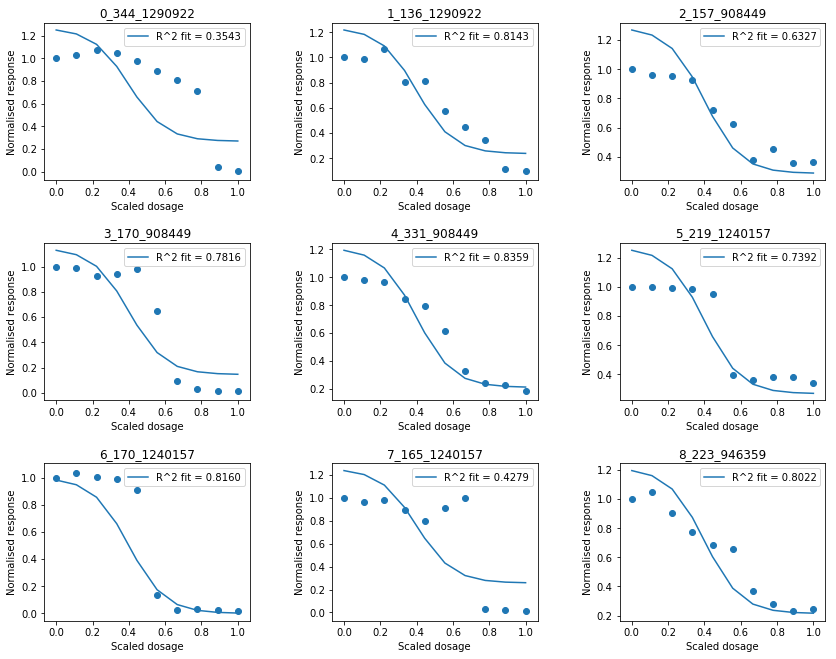

In [4]:
%%time
fitting_function = "sigmoid_4_param"
r2, fit_param = FittingColumn(df, df.index, x_columns=conc_columns, y_columns= response_norm,
                               fitting_function = fitting_function, default_param=True)
df[fitting_function+"_r2"] = r2
df[fitting_function] = fit_param
df= df[df[fitting_function+"_r2"]!=0]
print(df.shape)

ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                        indexes=df.index[:9],fitting_function = fitting_function, 
                                  fitting_parameters =fitting_function)

### sigmoid_Wang

100%|██████████| 7947/7947 [01:05<00:00, 122.05it/s]


(7947, 51)
Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)
CPU times: user 1min 1s, sys: 3.1 s, total: 1min 4s
Wall time: 1min 5s


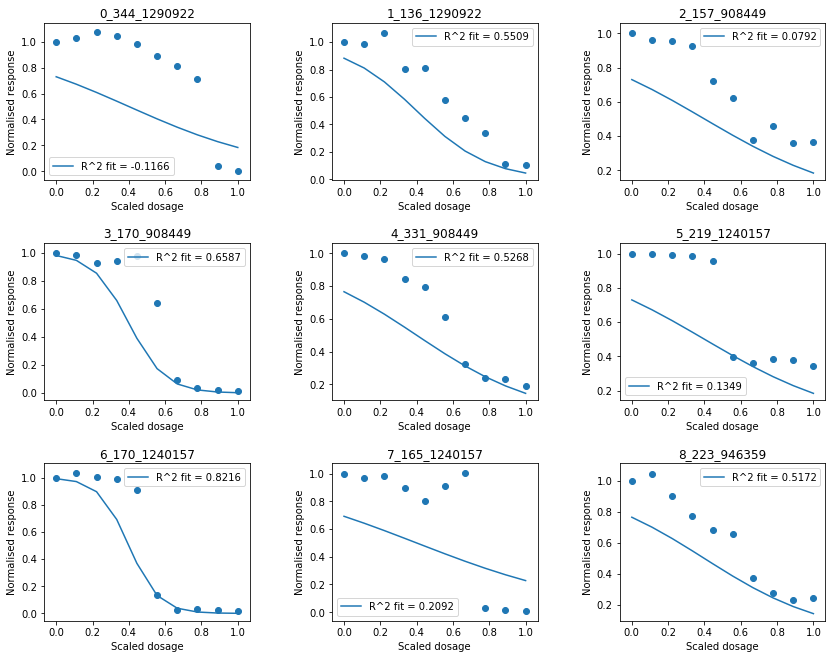

In [5]:
%%time
fitting_function = "sigmoid_Wang" 
# "sigmoid_Wang" we don't need default_param_number
r2, fit_param = FittingColumn(df, df.index, x_columns=conc_columns, y_columns= response_norm,
                               fitting_function = fitting_function, default_param=True)
df[fitting_function+"_r2"] = r2
df[fitting_function] = fit_param
df= df[df[fitting_function+"_r2"]!=0]
print(df.shape)

ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                        indexes=df.index[:9],fitting_function = fitting_function, 
                                  fitting_parameters =fitting_function)

### sigmoid_3_param

100%|██████████| 7947/7947 [01:05<00:00, 121.93it/s]


(7947, 53)
Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)
CPU times: user 1min 1s, sys: 2.02 s, total: 1min 3s
Wall time: 1min 5s


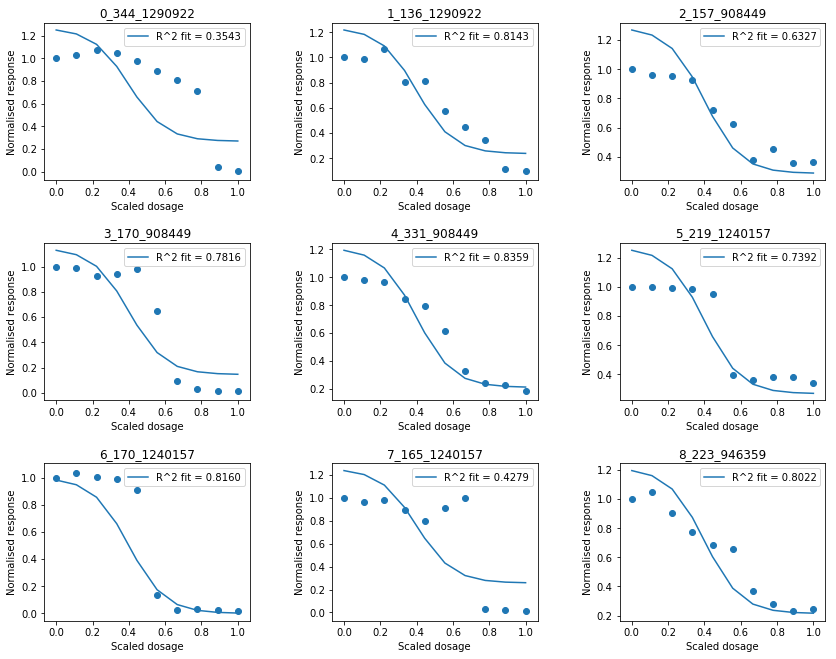

In [7]:
%%time
fitting_function = "sigmoid_3_param"

r2, fit_param = FittingColumn(df, df.index, x_columns=conc_columns, y_columns= response_norm,
                               fitting_function = fitting_function, default_param=True)
df[fitting_function+"_r2"] = r2
df[fitting_function] = fit_param
df= df[df[fitting_function+"_r2"]!=0]
print(df.shape)

ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                        indexes=df.index[:9],fitting_function = fitting_function, 
                                  fitting_parameters =fitting_function)

In [8]:
fitting_function="sigmoid_3_param"
df_compare_coef = pd.DataFrame()
all_param = np.stack(df[fitting_function].values, axis=0)
for i in range(all_param.shape[1]):
    df_compare_coef["param_"+str(i+1)+"_" + fitting_function]=all_param[:,i]
df_compare_coef.describe().loc[["max","min"], :]

,param_1_sigmoid_3_param,param_2_sigmoid_3_param,param_3_sigmoid_3_param
max,0.4,0.007997,4.582523e-01
min,0.4,-20.007966,1.000000e-10


### fsigmoid

100%|██████████| 7947/7947 [00:12<00:00, 637.34it/s]


(7947, 55)
Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)


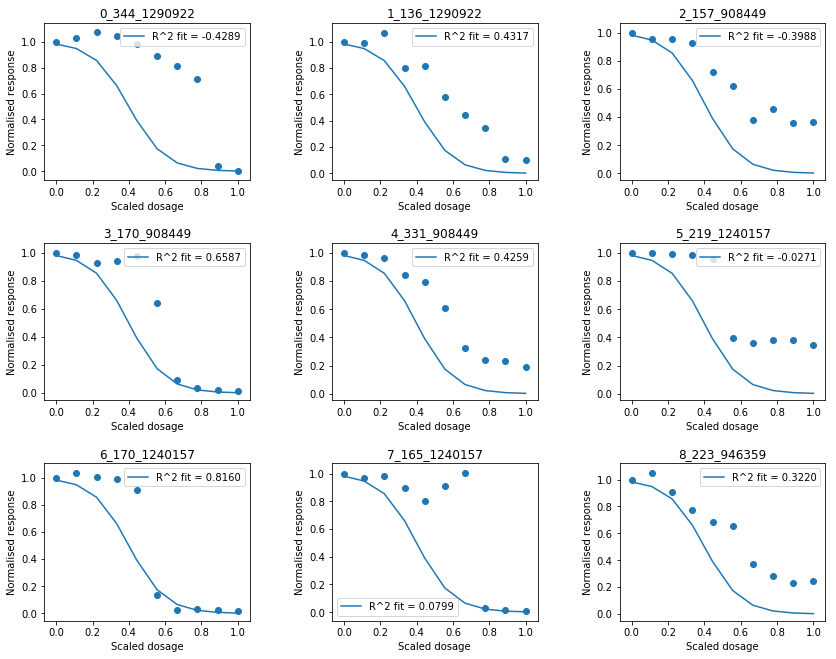

In [9]:
# %%time
fitting_function = "fsigmoid"

r2, fit_param = FittingColumn(df, df.index, x_columns=conc_columns, y_columns= response_norm,
                               fitting_function = fitting_function, default_param=True)
df[fitting_function+"_r2"] = r2
df[fitting_function] = fit_param
df= df[df[fitting_function+"_r2"]!=0]
print(df.shape)

ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                        indexes=df.index[:9],fitting_function = fitting_function, 
                                  fitting_parameters =fitting_function)

### logistic4

100%|██████████| 7947/7947 [00:13<00:00, 578.48it/s]


(7947, 57)
Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)
CPU times: user 13.1 s, sys: 500 ms, total: 13.6 s
Wall time: 13.9 s


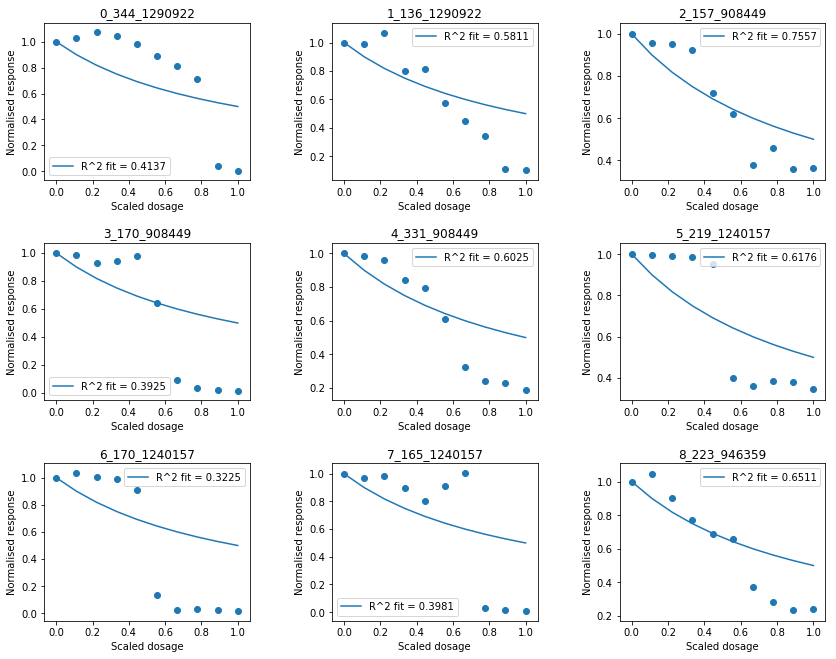

In [10]:
%%time
fitting_function = "logistic4"
r2, fit_param = FittingColumn(df, df.index, x_columns=conc_columns, y_columns= response_norm,
                               fitting_function = fitting_function, default_param=True)
df[fitting_function+"_r2"] = r2
df[fitting_function] = fit_param
df= df[df[fitting_function+"_r2"]!=0]
print(df.shape)

ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                        indexes=df.index[:9],fitting_function = fitting_function, 
                                  fitting_parameters =fitting_function)

### LL4

100%|██████████| 7947/7947 [01:11<00:00, 111.37it/s]


(7947, 59)
Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)
CPU times: user 1min 3s, sys: 2.32 s, total: 1min 5s
Wall time: 1min 11s


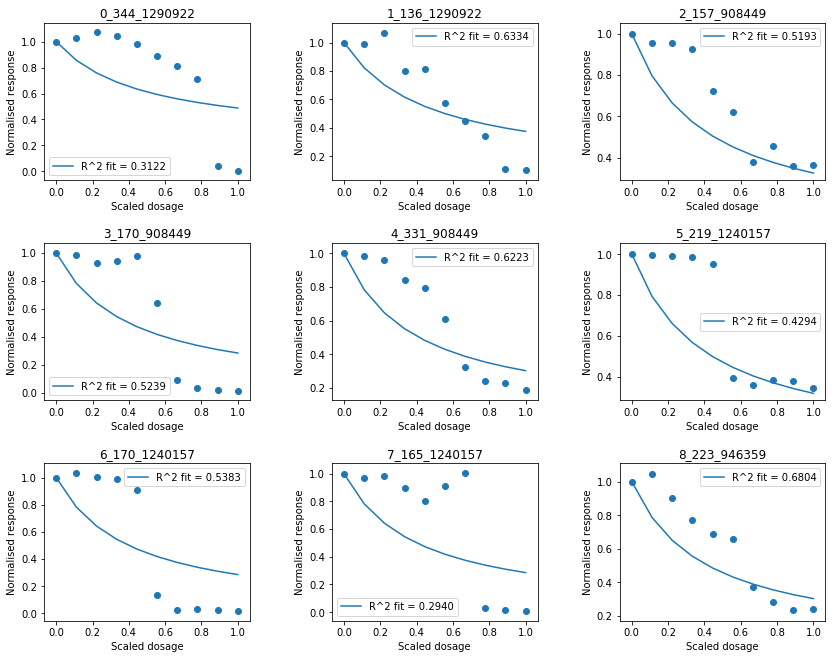

In [11]:
%%time
fitting_function = "ll4"
r2, fit_param = FittingColumn(df, df.index, x_columns=conc_columns, y_columns= response_norm,
                               fitting_function = fitting_function, default_param=True)
df[fitting_function+"_r2"] = r2
df[fitting_function] = fit_param
df= df[df[fitting_function+"_r2"]!=0]
print(df.shape)

ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                        indexes=df.index[:9],fitting_function = fitting_function, 
                                  fitting_parameters =fitting_function)

### ll4_R

100%|██████████| 7947/7947 [01:15<00:00, 105.91it/s]


(7947, 61)
Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)
CPU times: user 1min 10s, sys: 2.43 s, total: 1min 12s
Wall time: 1min 15s


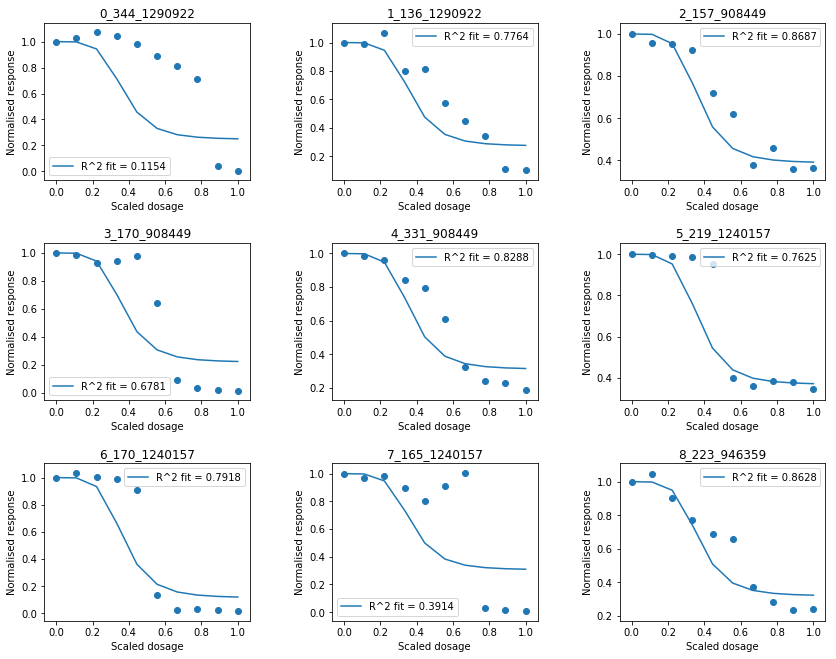

In [12]:
%%time
fitting_function = "ll4_R"
r2, fit_param = FittingColumn(df, df.index, x_columns=conc_columns, y_columns= response_norm,
                               fitting_function = fitting_function, default_param=True)
df[fitting_function+"_r2"] = r2
df[fitting_function] = fit_param
df= df[df[fitting_function+"_r2"]!=0]
print(df.shape)

ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                        indexes=df.index[:9],fitting_function = fitting_function, 
                                  fitting_parameters =fitting_function)

### logLogistR

100%|██████████| 7947/7947 [01:17<00:00, 102.31it/s]


(7947, 63)
Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)
CPU times: user 1min 11s, sys: 2.35 s, total: 1min 14s
Wall time: 1min 17s


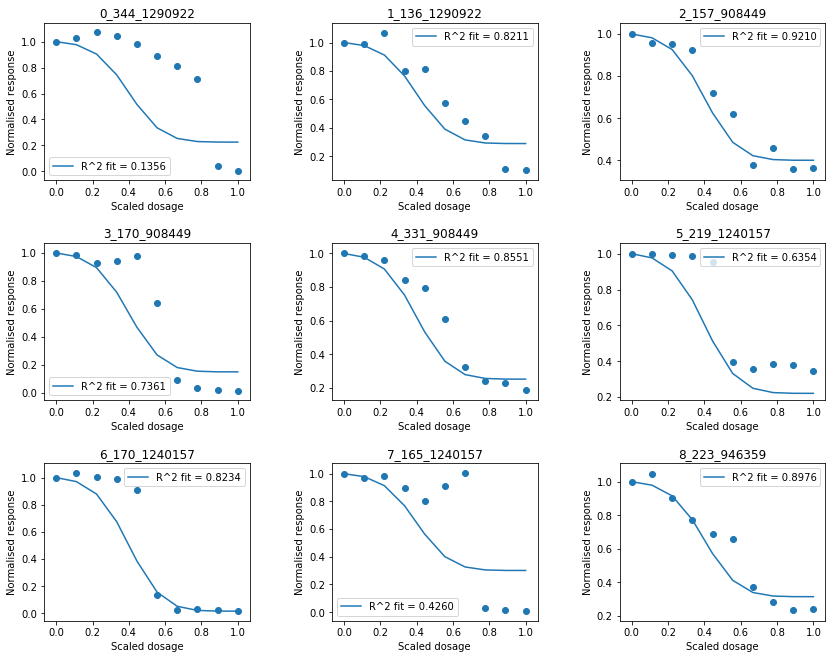

In [13]:
%%time
fitting_function = "logLogistR"
r2, fit_param = FittingColumn(df, df.index, x_columns=conc_columns, y_columns= response_norm,
                               fitting_function = fitting_function, default_param=True)
df[fitting_function+"_r2"] = r2
df[fitting_function] = fit_param
df= df[df[fitting_function+"_r2"]!=0]
print(df.shape)

ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                        indexes=df.index[:9],fitting_function = fitting_function, 
                                  fitting_parameters =fitting_function)

## Comparison of fitting models

In [14]:
functions = ["sigmoid_Wang", "fsigmoid", 
             "sigmoid_4_param", "sigmoid_3_param",
             "logistic4", "ll4", "ll4_R",
             "logLogistR"]
functions_dict= dict(list(enumerate(functions)))
r2_columns = [fitting_function+"_r2" for fitting_function in functions]

In [15]:
%%time
df_compare_coef = pd.DataFrame()
for func in functions:
    all_param = np.stack(df[func].values, axis=0)
    for i in range(all_param.shape[1]):
        df_compare_coef["param_"+str(i+1)+"_" + func]=all_param[:,i]

df_compare_coef.describe().loc[["min", "max"], :]       

CPU times: user 373 ms, sys: 24.1 ms, total: 397 ms
Wall time: 419 ms


,param_1_sigmoid_Wang,param_2_sigmoid_Wang,param_1_fsigmoid,param_2_fsigmoid,param_1_sigmoid_4_param,param_2_sigmoid_4_param,param_3_sigmoid_4_param,param_4_sigmoid_4_param,param_1_sigmoid_3_param,param_2_sigmoid_3_param,...,param_2_ll4,param_3_ll4,param_4_ll4,param_1_ll4_R,param_2_ll4_R,param_3_ll4_R,param_4_ll4_R,param_1_logLogistR,param_2_logLogistR,param_3_logLogistR
min,0.4,0.011352,0.4,-10.0,0.4,0.811465,-20.057826,1.000000e-10,0.4,-20.007966,...,0.799519,0.483927,2.933329e-14,-5.0,0.857969,4.134527,1.000000e-10,0.4,-4.0,1.000000e-10
max,0.4,0.566105,0.4,-10.0,0.4,1.300013,0.061093,4.582523e-01,0.4,0.007997,...,1.000000,2.976769,6.997259e-01,-5.0,1.000000,16.555654,6.669951e-01,0.4,-4.0,5.584583e-01


In [ ]:
 default_param_model = {"sigmoid_Wang": {"initial_guess": [0.4, 0.1], 
                                             "bounds": (0, 1)},
                           "fsigmoid" : {"initial_guess": [0.4, -10], 
                                          "bounds": ((0,-100), (1,-1))},
                           "sigmoid_4_param": {"initial_guess": [0.4, 1.0, -10, .0], 
                                                "bounds": ((0, 0.8, -100, 0), (1, 10, 1, 0.9))},
                           "sigmoid_3_param": {"initial_guess": [0.4, -10.0, .0],  
                                               "bounds": ((0, -100, 0), (1, 1, 0.9))},
                           "logistic4": {"initial_guess": [1.0, 1.0, 1.0, 0.0], 
                                        "bounds": ((0, 0.1, 0, 0), (1.5, 50, 1, 0.9))},
                            "ll4": {"initial_guess": [0.4, 1.0, 1.0, 0.0], 
                                    "bounds": ((0.1,0,0,0), (1, 1, 50, 1))},
                            "ll4_R": {"initial_guess": [-5, 1.0, 5.0, 0], 
                                 "bounds":((-10,0,0,0), (0, 1.0, 50, 1))},
                            "logLogistR": {"initial_guess": [0.4, -4, 0], 
                                          "bounds":((0,-30,0), (1,-2,1))}}

In [17]:
df["better_fitting"] = np.argmax(df[r2_columns].values, axis=1)
r2_col_res = r2_columns +["better_fitting"]
df["better_fitting"] = df["better_fitting"].map(functions_dict)
df[r2_col_res].head()

,sigmoid_Wang_r2,fsigmoid_r2,sigmoid_4_param_r2,sigmoid_3_param_r2,logistic4_r2,ll4_r2,ll4_R_r2,logLogistR_r2,better_fitting
0,-0.116574,-0.428939,0.354346,0.354346,0.413688,0.312168,0.115377,0.135633,logistic4
1,0.550872,0.431674,0.814296,0.814296,0.581149,0.633421,0.776439,0.821106,logLogistR
2,0.079232,-0.398810,0.632741,0.632741,0.755681,0.519311,0.868749,0.920953,logLogistR
3,0.658721,0.658721,0.781626,0.781626,0.392452,0.523853,0.678078,0.736144,sigmoid_4_param
4,0.526825,0.425877,0.835947,0.835947,0.602486,0.622271,0.828801,0.855076,logLogistR


In [18]:
df["better_fitting"].value_counts()

sigmoid_4_param    3333
logLogistR         1439
logistic4          1332
ll4_R              1084
sigmoid_Wang        428
sigmoid_3_param     174
ll4                 156
fsigmoid              1
Name: better_fitting, dtype: int64

In [20]:
r2_limit = 0.98
fitted_samples = {}
for function in functions:
    fitted_samples[function] = df[df[function+"_r2"]> r2_limit].shape[0]

pd.DataFrame(fitted_samples.values(), index=fitted_samples.keys(), columns= ["fitted_samples R2>"+str(r2_limit)])\
            .sort_values("fitted_samples R2>"+str(r2_limit), ascending=False)

,fitted_samples R2>0.98
logLogistR,396
ll4_R,350
sigmoid_Wang,321
sigmoid_3_param,308
sigmoid_4_param,306
fsigmoid,146
logistic4,0
ll4,0


In [21]:
r2_limit = 0.95
fitted_samples = {}
for function in functions:
    fitted_samples[function] = df[df[function+"_r2"]> r2_limit].shape[0]

pd.DataFrame(fitted_samples.values(), index=fitted_samples.keys(), columns= ["fitted_samples R2>"+str(r2_limit)])\
            .sort_values("fitted_samples R2>"+str(r2_limit), ascending=False)

,fitted_samples R2>0.95
logLogistR,1172
ll4_R,1047
sigmoid_4_param,1020
sigmoid_3_param,1017
sigmoid_Wang,713
fsigmoid,532
ll4,1
logistic4,0


In [22]:
r2_limit = 0.9
fitted_samples = {}
for function in functions:
    fitted_samples[function] = df[df[function+"_r2"]> r2_limit].shape[0]

pd.DataFrame(fitted_samples.values(), index=fitted_samples.keys(), columns= ["fitted_samples R2>"+str(r2_limit)])\
            .sort_values("fitted_samples R2>"+str(r2_limit), ascending=False)

,fitted_samples R2>0.9
logLogistR,2198
sigmoid_3_param,2074
sigmoid_4_param,2068
ll4_R,1926
sigmoid_Wang,1320
fsigmoid,1175
ll4,26
logistic4,0


### Conclusion:
**Bounds for coefficients ruined the curve fitting!!!** 
<br>But as soon as our our goal is to predict the real points and not statistics parameters
<br> it is better to use "unreal" values of the coefficients

In [ ]:
# @TODO partial bounds for coefficients